In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as sci
import time 
import threading
import sys
import multiprocessing as multiproc
import scipy.optimize as opt

# the function library
from projectlib import *

## Parameters

In [2]:
class Data:
    def __init__(self, alpha, beta, dimension, name, commuters_day, N):
        "Dimension gives the dimension of the system, i.e. number of cells"
        # ------- TO DO ---------
        # Depending on the system this has to be adjusted
        self.dimension = dimension
        
        "Alpha describes the rate of infection"
        self.alpha = alpha # Dimensions day^(-1)

        "Beta describes the recovery rate"
        self.beta = beta # Dimensions day^(-1)

        "p is the probability to die from the disease"
        self.p = 2.64e-2
        
        """
        Commuters is an array describing the commuters from and to the different cells. 
        The structure is: The entries in column i are how many commute from i to the cell of the row.
                          Thus, the entries of the row i describe how many commute from different cells to cell i.
        """

        self.commuters = np.array([np.ones(self.dimension) for i in range(self.dimension)])
        "load the txt with given name"
        file = np.loadtxt(name, delimiter="\t")
        "fill commuters with the entries from the file. Note the break statement so it doesn't go to far"
        i = 0
        for row in file:
            if i >= self.dimension:
                break
            self.commuters[i] = np.asarray(row[0:self.dimension])
            i += 1
        
        "Part of day that commuters are in other cells. This is the same value for all cells"
        self.commuters_day = commuters_day

        "Array of population in every cell"
        # ------- TO DO ---------
        # figure out how to best do this
        self.N = N

        
        
    def commutersFrom(self, cfrom):
        """Function to extract the commuters from a cell

        Args:
            cfrom (integer): the cell 

         Returns:
            array: array containing commuters from cfrom
        """
        # ------- TO DO ---------
        # optimize the algorithm
        "Sorting out the necessary entries into array a."
        a = np.zeros(self.dimension)
        for i in range(self.dimension):
            a[i] = self.commuters[i][cfrom]
            
        return a 
    
    def commutersTo(self, cto):
        """Function to return an array with number of commuters coming to cto from other cells.

        Args:
            cto (integer): the cell to which the commuters travel

        Returns:
            array: array containing the commuters to cto.
        """
        return self.commuters[cto][:]
       
        
        

## Functions

In [3]:


def function_of_system(timestep, functions,  data, methode, t0):
    """Function to calculate the time derivatives of the dynamic SIRD modell with commuters. This function uses multiple approachs for different variant of the system based on prior assumptions. 

        Args:
            functions (array): array with the functions that define the system of equations. Structure [S_1, ... , S_n, I_1, .... , I_n, R_1, ... , R_n, D_1, ... , D_n]
            timestep (float): time of timestep. t=1 is 1 day
            data (class): the class with the relevant data
            methode (string): dictates what methode is to be used. The choices are "constant", "heaviside"
            t0 (array): array with len = 3 filled with times at which the heaviside functions in the "heaviside" methode switch. 
                Note: all values of t0 have to be between 0 and 1.

        Returns:
            array: array containing the derivatives of functions at time t.
    """
    # array with infected
    Infected = functions[data.dimension:2*data.dimension]

    # making array with the effective infected Ieff
    Ieff = np.array([effective_infected(data.commutersTo, data.commutersFrom, data.N, i, Infected, data.dimension) for i in range(data.dimension)])

    # initializing the return array with the time derivatives of functions
    dfuncdt = np.ones(data.dimension*4)

    "~~~~~~~~~~~~~~~~~ See the PDF / LaTeX for further explanation of the equations ~~~~~~~~~~~~~~~~~~~~~~~~"

    # ------------------------------------
    # -      Constant Coefficients       -
    # ------------------------------------

    tt = 0.6

    if methode == "constant":
            
        # the for loop to fill dfuncdt

        for i in range(data.dimension):
            # see LaTeX for equations
            # dS/dt
            dfuncdt[i] =  - tt * data.alpha *  functions[i] * functions[i + data.dimension] - (1 - tt) * data.alpha * functions[i] * Ieff[i]

            # dI/dt \propto -dSdt
            dfuncdt[i + data.dimension] = - dfuncdt[i] - data.beta * functions[i + data.dimension]

            # dR/dt
            dfuncdt[i + 2 * data.dimension] = (1 - data.p) * data.beta * functions[i + data.dimension]

            # dD/dt
            dfuncdt[i + 3 * data.dimension] = data.p * data.beta * functions[i + data.dimension]


    # ------------------------------------
    # -      Heaviside Coefficients      -
    # ------------------------------------


    elif methode == "heaviside":


        # the for loop to fill dfuncdt
        for i in range(data.dimension):
            # see LaTeX for equations
            # dS/dt
            dfuncdt[i] = - data.alpha * (periodic_heaviside(timestep, t0[0]) + periodic_heaviside(timestep, t0[2]) - 1) * functions[i] * functions[i + data.dimension] - (periodic_heaviside(timestep, t0[1]) - periodic_heaviside(timestep, t0[2])) * data.alpha * functions[i] * Ieff[i]

            # dI/dt \propto -dSdt
            dfuncdt[i + data.dimension] = - dfuncdt[i] - data.beta * functions[i + data.dimension]

            # dR/dt
            dfuncdt[i + 2 * data.dimension] = (1 - data.p) * data.beta * functions[i + data.dimension]

            # dD/dt
            dfuncdt[i + 3 * data.dimension] = data.p * data.beta * functions[i + data.dimension]

    
    
    
    
    
    
    
    # returning the derivatives at time t
    return dfuncdt



# Function for using scipy.integrate.odeint, as the arguments are switched
def system_function(functions, timestep, data, methode, t0):
    return function_of_system(timestep, functions, data, methode, t0)




In [4]:
dimension = 38
a =  np.loadtxt("./Internal Data/initial_data.txt")
initCond = np.zeros(dimension*4)

b = np.genfromtxt("./Internal Data/initial_data.txt")


for i in range(dimension):
    initCond[i] = b[i, 0]
    initCond[i + dimension] = b[i, 1]
    initCond[i + 2*dimension] = b[i, 2]
    initCond[i + 3*dimension] = b[i, 3]

 
N = region_setup(dimension)[0]


tzero = np.array([0, 0.4, 0.8])


simulation001 = Data(0.2, 1/14, dimension, "Pendler.txt", 0.6, import_rki_data(N, 7)[2])

t = np.linspace(0, 100, 100000)

sol1 = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation001, "heaviside", tzero), t_eval=t)
sol = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation001, "constant", tzero), t_eval=t, dense_output=True)




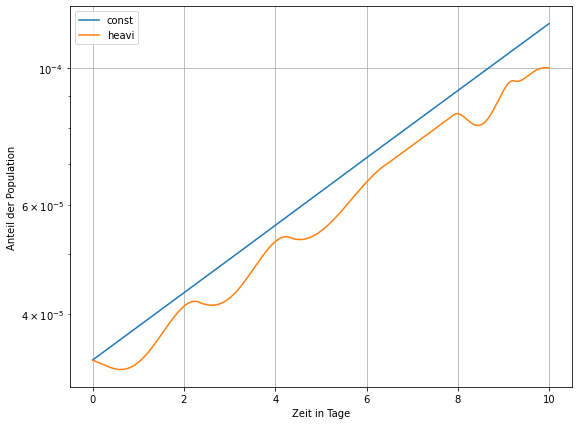

In [175]:
fig = plt.figure(figsize=(9, 7))
plt.plot(sol.t[:10000], sol.y[43, :10000], label="const")
plt.plot(sol1.t[:10000], sol1.y[43, :10000], label="heavi")
plt.legend(loc="upper left")
plt.grid()
plt.yscale("log")
plt.xlabel("Zeit in Tage")
plt.ylabel("Anteil der Population")
plt.show()




In [176]:
simulation001 = Data(0.4, 1/14, dimension, "Pendler.txt", 0.6, import_rki_data(N, 7)[2])
simulation002 = Data(0.3, 1/14, dimension, "Pendler.txt", 0.6, import_rki_data(N, 7)[2])
simulation003 = Data(0.2, 1/14, dimension, "Pendler.txt", 0.6, import_rki_data(N, 7)[2])
simulation004 = Data(0.1, 1/14, dimension, "Pendler.txt", 0.6, import_rki_data(N, 7)[2])

t = np.linspace(0, 100, 100000)


sol = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation001, "heaviside", tzero), t_eval=t)
sol1 = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation001, "constant", tzero), t_eval=t, dense_output=True)
sol2 = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation002, "heaviside", tzero), t_eval=t)
sol3 = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation002, "constant", tzero), t_eval=t, dense_output=True)
sol4 = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation003, "heaviside", tzero), t_eval=t)
sol5 = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation003, "constant", tzero), t_eval=t, dense_output=True)
sol6 = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation004, "heaviside", tzero), t_eval=t)
sol7 = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation004, "constant", tzero), t_eval=t, dense_output=True)



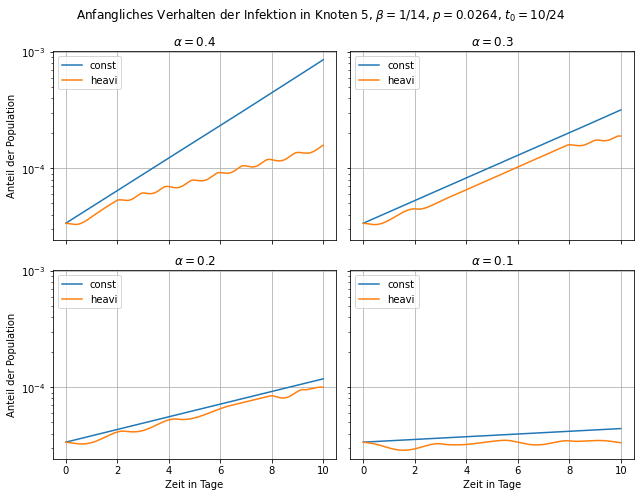

In [177]:
fig, axs = plt.subplots(2, 2, figsize=(9,7), sharex=True, sharey=True)

fig.suptitle(r"Anfangliches Verhalten der Infektion in Knoten 5, $\beta = 1/14$, $p = 0.0264$, $t_0 = 10/24$")


axs[0, 0].plot(sol1.t[:10000], sol1.y[43, :10000], label="const")
axs[0, 0].plot(sol.t[:10000], sol.y[43, :10000], label="heavi")

axs[0, 0].legend(loc="upper left")
axs[0, 0].grid()
axs[0, 0].set_yscale("log")
axs[0, 0].set_ylabel("Anteil der Population")
axs[0, 0].set_title(r"$\alpha = 0.4$")


axs[0, 1].plot(sol3.t[:10000], sol3.y[43, :10000], label="const")
axs[0, 1].plot(sol2.t[:10000], sol2.y[43, :10000], label="heavi")

axs[0, 1].legend(loc="upper left")
axs[0, 1].grid()
axs[0, 1].set_yscale("log")
axs[0, 1].set_title(r"$\alpha = 0.3$")



axs[1, 0].plot(sol5.t[:10000], sol5.y[43, :10000], label="const")
axs[1, 0].plot(sol4.t[:10000], sol4.y[43, :10000], label="heavi")

axs[1, 0].legend(loc="upper left")
axs[1, 0].grid()
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("Zeit in Tage")
axs[1, 0].set_ylabel("Anteil der Population")
axs[1, 0].set_title(r"$\alpha = 0.2$")


axs[1, 1].plot(sol7.t[:10000], sol7.y[43, :10000], label="const")
axs[1, 1].plot(sol6.t[:10000], sol6.y[43, :10000], label="heavi")

axs[1, 1].legend(loc="upper left")
axs[1, 1].grid()
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("Zeit in Tage")
axs[1, 1].set_title(r"$\alpha = 0.1$")

fig.tight_layout()

plt.savefig("./Media/Plots/exp/LogY01.pdf", dpi=200, bbox_inches="tight")

plt.show()



## Some Plotting

In [178]:
dimension = 38
initCond = np.zeros(dimension*4)

b = np.genfromtxt("./Internal Data/initial_data.txt")


for i in range(dimension):
    initCond[i] = b[i, 0]
    initCond[i + dimension] = b[i, 1]
    initCond[i + 2*dimension] = b[i, 2]
    initCond[i + 3*dimension] = b[i, 3]

 
N = region_setup(dimension)[0]


tzero1 = np.array([0, 0.4, 0.8])
tzero2 = np.array([0, 0.4, 0.7])
tzero3 = np.array([0, 0.4, 0.6])
tzero4 = np.array([0, 0.4, 0.9])
tzero5 = np.array([0, 0.4, 1.0])

simulation001 = Data(0.4, 1/14, dimension, "Pendler.txt", 0.6, import_rki_data(N, 7)[2])

t = np.linspace(0, 100, 100000)

sol1 = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation001, "heaviside", tzero1), t_eval=t)
sol2 = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation001, "heaviside", tzero2), t_eval=t)
sol3 = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation001, "heaviside", tzero3), t_eval=t)
sol4 = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation001, "heaviside", tzero4), t_eval=t)
sol5 = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation001, "heaviside", tzero5), t_eval=t)



In [179]:
import numpy as np
import scipy.integrate as sci
import time 
import threading
import sys
import multiprocessing as multiproc
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool 

# the function library
from projectlib import *
import h5py


# for timing
t3 = time.time()


def plotting(index):
    """Function for plotting the effect that alpha has on the differential equations
    Args:
        index (int): index of cell
    """
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(2, 2, figsize=(9,7), sharex=True, sharey=True)
    fig.suptitle(r"Graphische Darstellung der DGl in Knoten %g, $\beta = 1/14$, $p = 0.0264$, $t_0 = 10/24$, $\alpha = 0.4$" % (index))

    axs[0, 0].set_title("S")
    axs[0, 0].set_ylabel("Teil der Population")
    axs[0, 0].plot(sol1.t, sol1.y[index, :], "b", label=r"$[0, 0.4, 0.8]$")
    axs[0, 0].plot(sol2.t, sol2.y[index, :], "r", label=r"$[0, 0.4, 0.7]$")
    axs[0, 0].plot(sol3.t, sol3.y[index, :], "g", label=r"$[0, 0.4, 0.6]$")
    axs[0, 0].plot(sol4.t, sol4.y[index, :], "k", label=r"$[0, 0.4, 0.9]$")
    axs[0, 0].plot(sol5.t, sol5.y[index, :], "m", label=r"$[0, 0.4, 1.0]$")
    axs[0, 0].legend(loc="upper right")
    axs[0, 0].grid()


    axs[0, 1].set_title("I")
    axs[0, 1].plot(sol1.t, sol1.y[index + dimension, :], "b", label=r"$[0, 0.4, 0.8]$")
    axs[0, 1].plot(sol2.t, sol2.y[index + dimension, :], "r", label=r"$[0, 0.4, 0.7]$")
    axs[0, 1].plot(sol3.t, sol3.y[index + dimension, :], "g", label=r"$[0, 0.4, 0.6]$")
    axs[0, 1].plot(sol4.t, sol4.y[index + dimension, :], "k", label=r"$[0, 0.4, 0.9]$")
    axs[0, 1].plot(sol5.t, sol5.y[index + dimension, :], "m", label=r"$[0, 0.4, 1.0]$")
    axs[0, 1].legend(loc="upper right")
    axs[0, 1].grid()


    axs[1, 0].set_title("R")
    axs[1, 0].set_xlabel("Zeit in Tage")
    axs[1, 0].set_ylabel("Teil der Population")
    axs[1, 0].plot(sol1.t, sol1.y[index + 2*dimension, :], "b", label=r"$[0, 0.4, 0.8]$")
    axs[1, 0].plot(sol2.t, sol2.y[index + 2*dimension, :], "r", label=r"$[0, 0.4, 0.7]$")
    axs[1, 0].plot(sol3.t, sol3.y[index + 2*dimension, :], "g", label=r"$[0, 0.4, 0.6]$")
    axs[1, 0].plot(sol4.t, sol4.y[index + 2*dimension, :], "k", label=r"$[0, 0.4, 0.9]$")
    axs[1, 0].plot(sol5.t, sol5.y[index + 2*dimension, :], "m", label=r"$[0, 0.4, 1.0]$")
    axs[1, 0].legend(loc="upper left")
    axs[1, 0].grid()


    axs[1, 1].set_title("D")
    axs[1, 1].set_xlabel("Zeit in Tage")
    axs[1, 1].plot(sol1.t, sol1.y[index + 3*dimension, :], "b", label=r"$[0, 0.4, 0.8]$")
    axs[1, 1].plot(sol2.t, sol2.y[index + 3*dimension, :], "r", label=r"$[0, 0.4, 0.7]$")
    axs[1, 1].plot(sol3.t, sol3.y[index + 3*dimension, :], "g", label=r"$[0, 0.4, 0.6]$")
    axs[1, 1].plot(sol4.t, sol4.y[index + 3*dimension, :], "k", label=r"$[0, 0.4, 0.9]$")
    axs[1, 1].plot(sol5.t, sol5.y[index + 3*dimension, :], "m", label=r"$[0, 0.4, 1.0]$")
    axs[1, 1].legend(loc="upper right")
    axs[1, 1].grid()

    plt.savefig("./Media/Plots/part/partplot_%g.pdf" % index, dpi=200)
    plt.close(fig)




if __name__ == "__main__":
    for i in range(38):
        plotting(i)
    
    """
    pool = Pool(4)
    pool.map(plotting, range(38))
    """
    """
    arg = [(i,) for i in range(38)]
    print(tuple(arg))
    pool = ThreadPool(2)
    pool.starmap(plotting, arg) 
    pool.close() 
    pool.join()
    """
    
t4 = time.time()
print("The program took ", t4- t3, "s")

The program took  50.90882968902588 s


In [180]:
print(np.shape(sol1.t))
print(np.shape(sol2.t))
print(np.shape(sol3.t))
print(np.shape(sol4.t))
print(np.shape(sol5.t))

(100000,)
(100000,)
(100000,)
(100000,)
(100000,)


In [181]:
print(sol1.message)
print(sol2.message)
print(sol3.message)
print(sol4.message)
print(sol5.message)

The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.


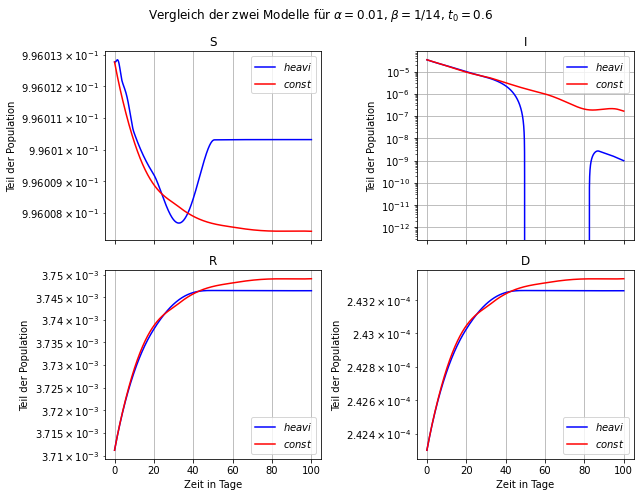

In [182]:
dimension = 38
a =  np.loadtxt("./Internal Data/initial_data.txt")
initCond = np.zeros(dimension*4)

b = np.genfromtxt("./Internal Data/initial_data.txt")


for i in range(dimension):
    initCond[i] = b[i, 0]
    initCond[i + dimension] = b[i, 1]
    initCond[i + 2*dimension] = b[i, 2]
    initCond[i + 3*dimension] = b[i, 3]

 
N = region_setup(dimension)[0]


tzero = np.array([0, 0.4, 0.8])


simulation001 = Data(0.01, 1/14, dimension, "Pendler.txt", 0.6, import_rki_data(N, 7)[2])

t = np.linspace(0, 100, 100000)

sol1 = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation001, "heaviside", tzero), t_eval=t)
sol2 = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation001, "constant", tzero), t_eval=t, dense_output=True)

""""
fig = plt.figure(figsize=(9, 7))
#plt.plot(sol.t[:10000], sol.y[43, :10000], label="const")
#plt.plot(sol1.t[:10000], sol1.y[43, :10000], label="heavi")
plt.plot(sol.t[:], sol.y[5+3*38, :], label="const")
plt.plot(sol1.t[:], sol1.y[5+3*38, :], label="heavi")
plt.legend(loc="upper left")
plt.grid()
plt.yscale("log")
plt.xlabel("Zeit in Tage")
plt.ylabel("Anteil der Population")
plt.show()


"""

fig, axs = plt.subplots(2, 2, figsize=(9,7), sharex=True)
fig.suptitle(r"Vergleich der zwei Modelle für $\alpha = 0.01$, $\beta = 1/14$, $t_0 = 0.6$")

axs[0, 0].set_title("S")
axs[0, 0].set_ylabel("Teil der Population")
axs[0, 0].set_ylabel("Teil der Population")
axs[0, 0].set_yscale("log")
axs[0, 0].plot(sol1.t, sol1.y[5, :], "b", label=r"$heavi$")
axs[0, 0].plot(sol2.t, sol2.y[5, :], "r", label=r"$const$")
axs[0, 0].legend(loc="upper right")
axs[0, 0].grid()


axs[0, 1].set_title("I")
axs[0, 1].set_ylabel("Teil der Population")
axs[0, 1].set_yscale("log")
axs[0, 1].plot(sol1.t, sol1.y[5 + dimension, :], "b", label=r"$heavi$")
axs[0, 1].plot(sol2.t, sol2.y[5 + dimension, :], "r", label=r"$const$")
axs[0, 1].legend(loc="upper right")
axs[0, 1].grid()


axs[1, 0].set_title("R")
axs[1, 0].set_xlabel("Zeit in Tage")
axs[1, 0].set_yscale("log")
axs[1, 0].set_ylabel("Teil der Population")
axs[1, 0].plot(sol1.t, sol1.y[5 + 2*dimension, :], "b", label=r"$heavi$")
axs[1, 0].plot(sol2.t, sol2.y[5 + 2*dimension, :], "r", label=r"$const$")
axs[1, 0].legend(loc="lower right")
axs[1, 0].grid()


axs[1, 1].set_title("D")
axs[1, 1].set_xlabel("Zeit in Tage")
axs[1, 1].set_yscale("log")
axs[1, 1].set_ylabel("Teil der Population")
axs[1, 1].plot(sol1.t, sol1.y[5 + 3*dimension, :], "b", label=r"$heavi$")
axs[1, 1].plot(sol2.t, sol2.y[5 + 3*dimension, :], "r", label=r"$const$")
axs[1, 1].legend(loc="lower right")
axs[1, 1].grid()

fig.tight_layout()

plt.savefig("./Media/Plots/small/small1.pdf", dpi=200)


In [4]:
dimension = 38
a =  np.loadtxt("./Internal Data/initial_data.txt")
initCond = np.zeros(dimension*4)

b = np.genfromtxt("./Internal Data/initial_data.txt")


for i in range(dimension):
    initCond[i] = b[i, 0]
    initCond[i + dimension] = b[i, 1]
    initCond[i + 2*dimension] = b[i, 2]
    initCond[i + 3*dimension] = b[i, 3]

 
N = region_setup(dimension)[0]


tzero = np.array([0, 0.4, 0.8])


simulation001 = Data(0.4, 1/14, dimension, "Pendler.txt", 0.6, import_rki_data(N, 7)[2])

t = np.linspace(0, 100, 100000)

sol1 = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation001, "heaviside", tzero), t_eval=t)
sol2 = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation001, "constant", tzero), t_eval=t, dense_output=True)


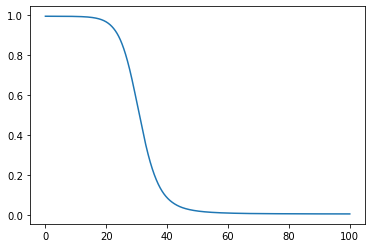

In [7]:
plt.plot(sol2.t, sol2.y[5, :])

In [8]:
print(import_rki_data(N, 7)[2])

[ 275817.   70458.  136292.  140251.  132285.  326041.  213310.  236764.
  202137.  100629.  100006.   83416. 1157115.  157820.  148549.  347514.
  334195.  364938.  307839.  301785.  259777.  156406.  179673.  120719.
  118974.   42250.  102232.   74212.  134942.  189125.  237565.  170923.
   91297.  124371.  119622.  124371.  104291.  134801.]


In [9]:
M = region_setup(dimension)[0]
N = import_rki_data(M, 7)[2]
print(N)

[ 275817.   70458.  136292.  140251.  132285.  326041.  213310.  236764.
  202137.  100629.  100006.   83416. 1157115.  157820.  148549.  347514.
  334195.  364938.  307839.  301785.  259777.  156406.  179673.  120719.
  118974.   42250.  102232.   74212.  134942.  189125.  237565.  170923.
   91297.  124371.  119622.  124371.  104291.  134801.]


# Boundaries

## Preparations, Sim Runs

In [5]:
dimension = 38
a =  np.loadtxt("./Internal Data/initial_data.txt")
initCond = np.zeros(dimension*4)

b = np.genfromtxt("./Internal Data/initial_data.txt")


for i in range(dimension):
    initCond[i] = b[i, 0]
    initCond[i + dimension] = b[i, 1]
    initCond[i + 2*dimension] = b[i, 2]
    initCond[i + 3*dimension] = b[i, 3]

 
N = region_setup(dimension)[0]


tzero = np.array([0, 0.4, 0.8])

simulation001 = Data(0.01, 1/14,38, "Pendler.txt", 0.6, import_rki_data(N, 7)[2])

t = np.linspace(0, 100, 10000)

sol1_38 = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation001, "heaviside", tzero), t_eval=t)
sol_38 = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation001, "constant", tzero), t_eval=t, dense_output=True)

In [6]:
dimension = 12
a =  np.loadtxt("./Internal Data/initial_data.txt")
initCond = np.zeros(dimension*4)

b = np.genfromtxt("./Internal Data/initial_data.txt")


for i in range(dimension):
    initCond[i] = b[i, 0]
    initCond[i + dimension] = b[i, 1]
    initCond[i + 2*dimension] = b[i, 2]
    initCond[i + 3*dimension] = b[i, 3]

 
N = region_setup(dimension)[0]


tzero = np.array([0, 0.4, 0.8])

simulation002 = Data(0.01, 1/14,12, "Pendler.txt", 0.6, import_rki_data(N, 7)[2])

t = np.linspace(0, 100, 10000)

sol1_12 = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation002, "heaviside", tzero), t_eval=t)
sol_12 = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation002, "constant", tzero), t_eval=t, dense_output=True)

In [7]:
# Degree Distribution

pendler = np.loadtxt("Pendler.txt")
degree_dist = np.zeros((38))
for i in range(38):
    for j in range (38):
        if(pendler[i][j] != 0):
            degree_dist[i] += 1
            degree_dist[j] += 1

## Analysis for Region 38 (by degree distribution)

### Constant vs RKI

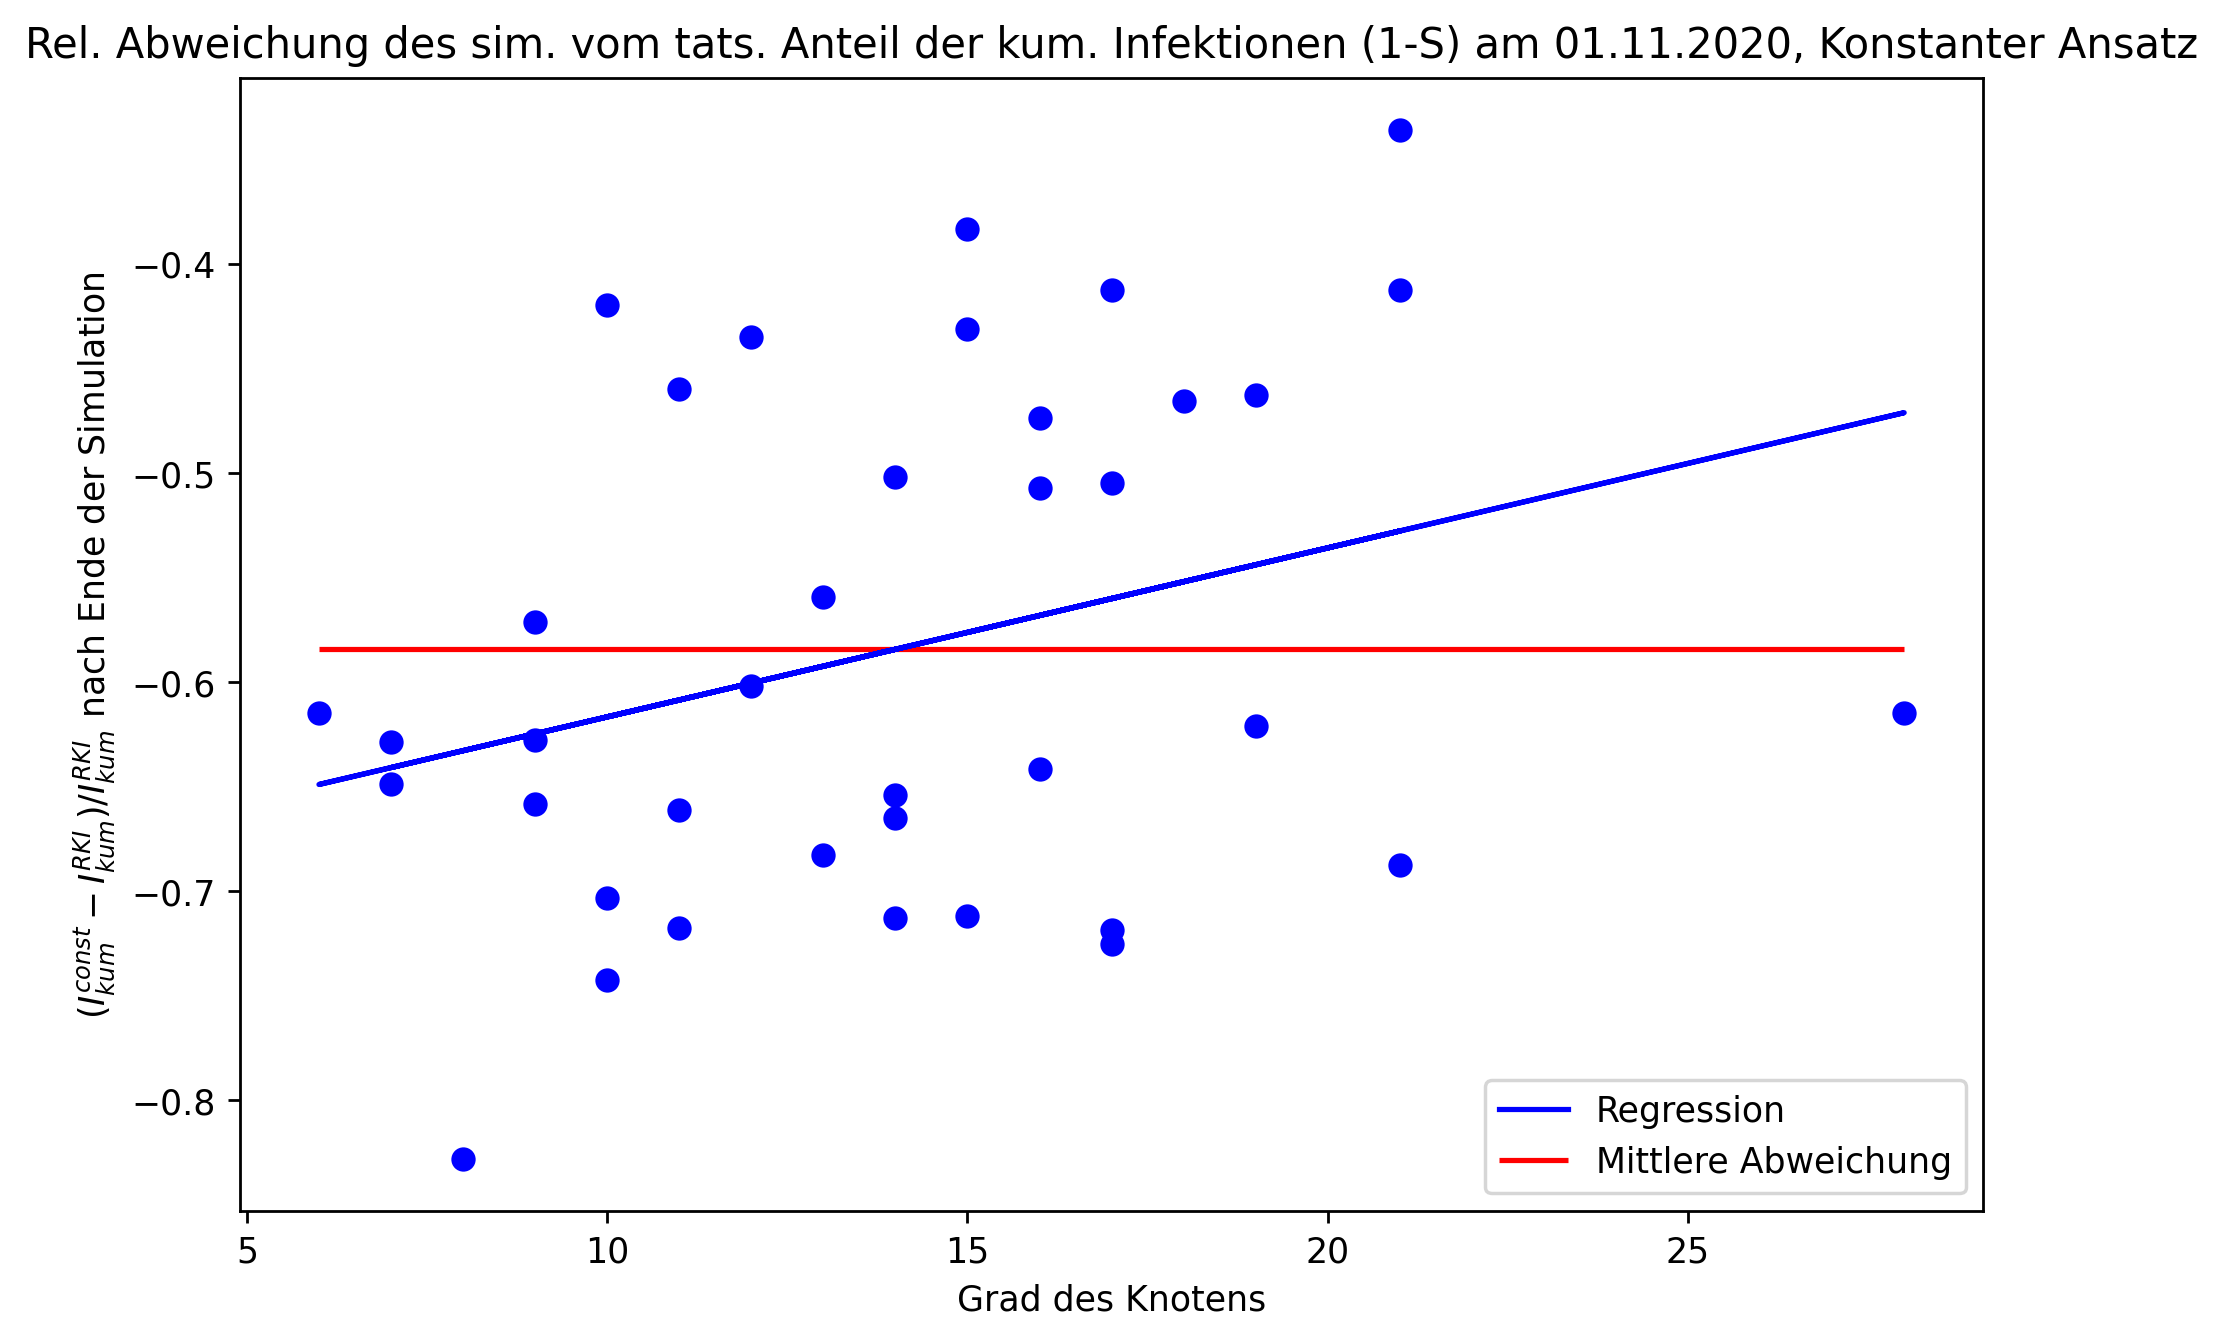

In [11]:
#We are interested in the cumulative amount of infected (1-S) at the end of the observed time interval:

RKI_data = np.load("Internal Data/timeline.npy")

# Compilation

diff_cum_I_final_c = np.zeros(38)
RKI=np.zeros(38)
for i in range(38):
    diff_cum_I_final_c[i] = -(1-RKI_data[i][0][-1]) + (1-sol_38.y[i][-1])
    RKI[i] = (1-RKI_data[i][0][-1])
avg_diff_cum_I_final_c=np.mean(diff_cum_I_final_c/RKI)

# Regression

def fc(x, a, b): 
	return a*x+b
p0 = [0, 0.1]
fitc, errc = opt.curve_fit(fc, degree_dist, diff_cum_I_final_c/RKI, p0)

plt.figure(figsize=(9,6),dpi=250)
plt.title("Rel. Abweichung des sim. vom tats. Anteil der kum. Infektionen (1-S) am 01.11.2020, Konstanter Ansatz")
plt.xlabel('Grad des Knotens')
plt.ylabel(r"$(I_{kum}^{const}-I_{kum}^{RKI})/I_{kum}^{RKI}$ nach Ende der Simulation")
plt.scatter(degree_dist,diff_cum_I_final_c/RKI,marker='o',color='blue')
plt.plot(degree_dist, [fc(d, *fitc) for d in degree_dist], label="Regression",color='blue')
plt.hlines(avg_diff_cum_I_final_c,6,28,color='red',label='Mittlere Abweichung')
plt.legend(loc='lower right')
plt.savefig("Media/Boundaries/Boundaries_38_degree_dist_c.pdf")

In [12]:
from scipy import stats
r_h_p=stats.pearsonr(degree_dist,diff_cum_I_final_c/RKI)[0]
r_h_s=stats.spearmanr(degree_dist,diff_cum_I_final_c/RKI)[0]
print("Korrelationskoeffizient (Pearson) r=",r_h_p)
print("Korrelationskoeffizient (Spearman) r=",r_h_s)

Korrelationskoeffizient (Pearson) r= 0.3102147995012958
Korrelationskoeffizient (Spearman) r= 0.2966548955791979


### Heaviside

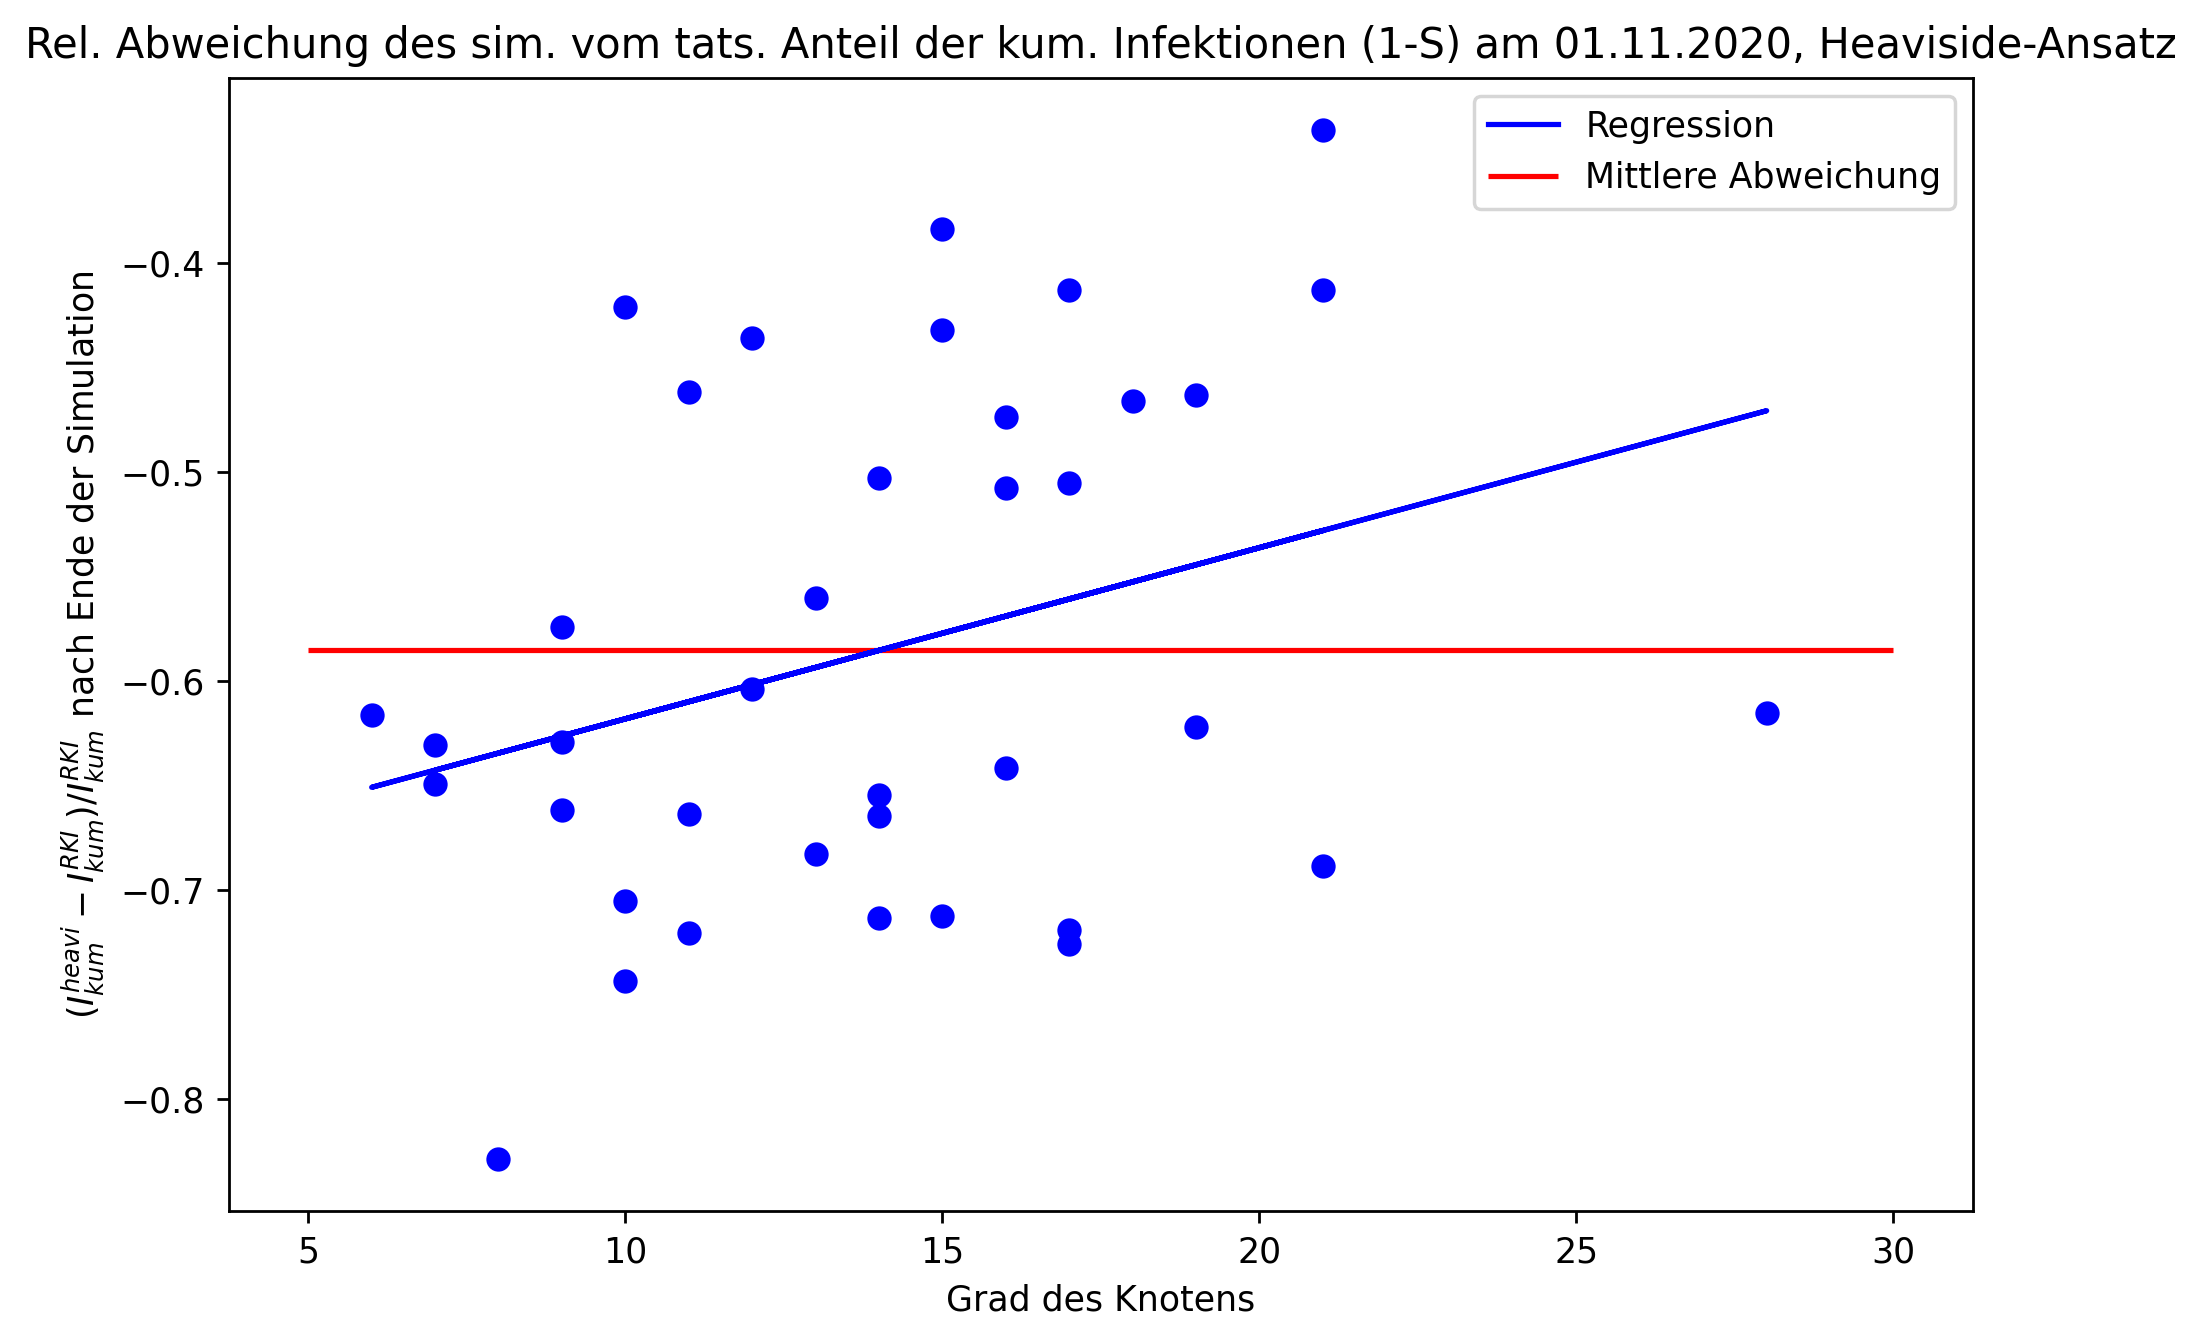

In [13]:
# Compilation

diff_cum_I_final_h = np.zeros(38)
RKI=np.zeros(38)
for i in range(38):
    diff_cum_I_final_h[i] = -(1-RKI_data[i][0][-1]) + (1-sol1_38.y[i][-1])
    RKI[i] = (1-RKI_data[i][0][-1])
avg_diff_cum_I_final_h=np.mean(diff_cum_I_final_h/RKI)

# Regression

def fh(x, a, b): 
	return a*x+b
p0 = [0, 0.1]
fith, errh = opt.curve_fit(fh, degree_dist, diff_cum_I_final_h/RKI, p0)

# Plot

plt.figure(figsize=(9,6),dpi=250)
plt.title("Rel. Abweichung des sim. vom tats. Anteil der kum. Infektionen (1-S) am 01.11.2020, Heaviside-Ansatz")
plt.xlabel('Grad des Knotens')
plt.ylabel(r"$(I_{kum}^{heavi}-I_{kum}^{RKI})/I_{kum}^{RKI}$ nach Ende der Simulation")
plt.scatter(degree_dist,diff_cum_I_final_h/RKI,marker='o',color='blue')
plt.hlines(avg_diff_cum_I_final_h,5,30,color='red',label='Mittlere Abweichung')
plt.plot(degree_dist, [fh(d, *fith) for d in degree_dist], label="Regression",color='blue')
plt.legend()
plt.savefig("Media/Boundaries/Boundaries_38_degree_dist_h.pdf")

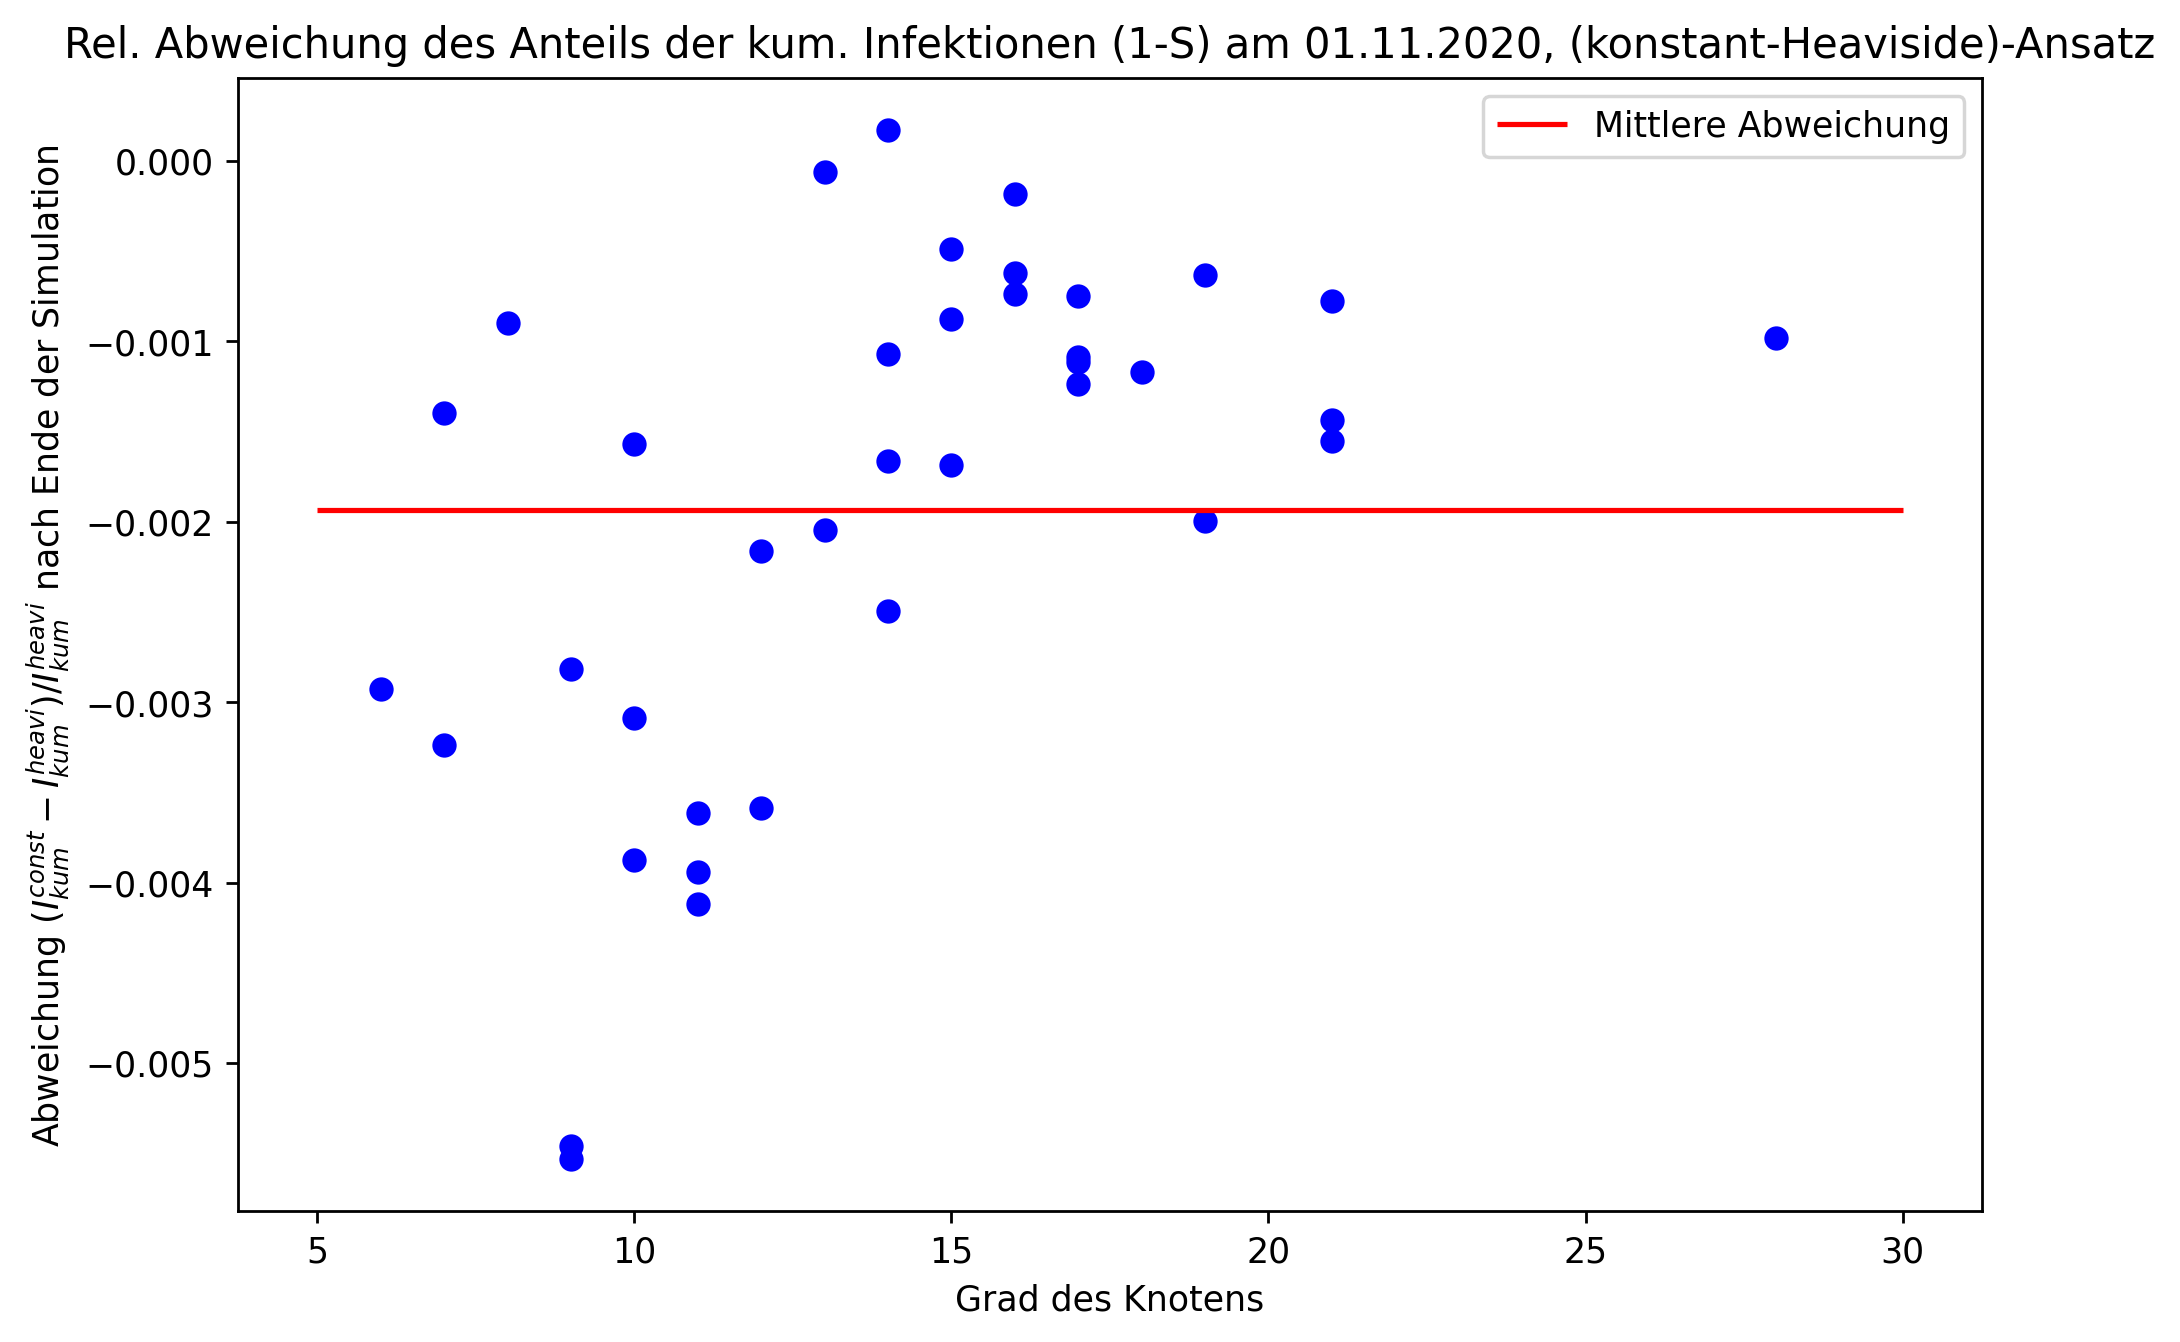

In [14]:
plt.figure(figsize=(9,6),dpi=250)
plt.title("Rel. Abweichung des Anteils der kum. Infektionen (1-S) am 01.11.2020, (konstant-Heaviside)-Ansatz")
plt.xlabel('Grad des Knotens')
plt.ylabel(r"Abweichung $(I_{kum}^{const}-I_{kum}^{heavi})/I_{kum}^{heavi}$ nach Ende der Simulation")
plt.scatter(degree_dist,(diff_cum_I_final_c - diff_cum_I_final_h)/diff_cum_I_final_h,marker='o',color='blue')
plt.hlines((avg_diff_cum_I_final_c-avg_diff_cum_I_final_h)/avg_diff_cum_I_final_h,5,30,color='red',label='Mittlere Abweichung')
plt.legend()
plt.savefig("Media/Boundaries/Boundaries_38_degree_dist_c-h.pdf")

## Comparison Region 12 vs Region 12/38
Comparison of cumulative amount of infected at the end of the 100 day interval

### Constant
Note that RKI data ranks higher than both (12 in 38), (12 einzeln) methods, to be mentioned in documentation.

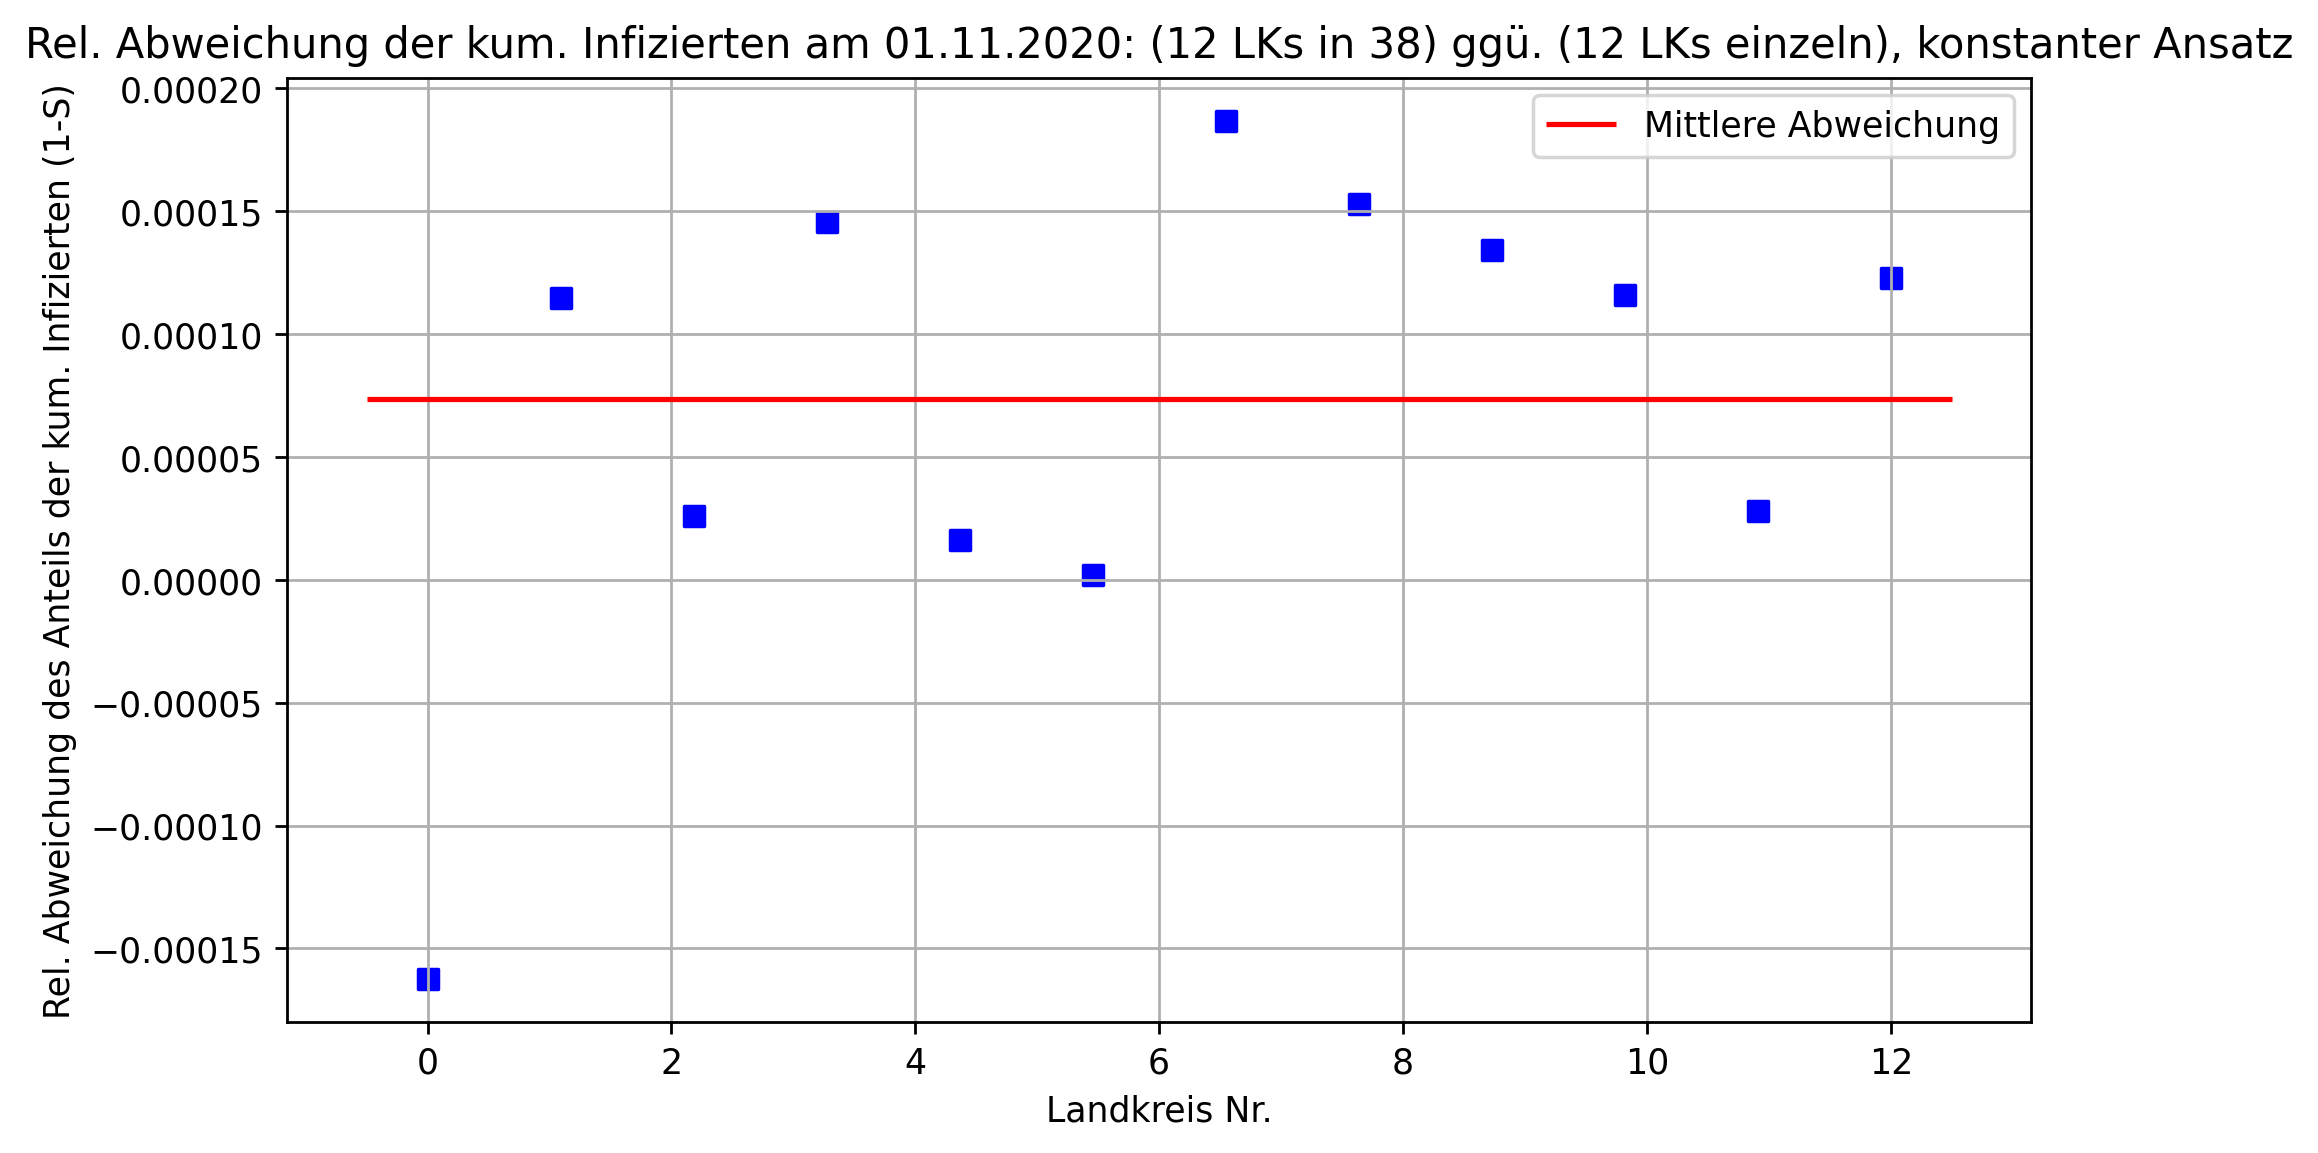

In [15]:
RKI_reference = np.zeros(12)
small_sim_c = np.zeros(12)
large_sim_c = np.zeros(12)

for i in range(12):
    RKI_reference[i] = (1-RKI_data[i][0][-1])
    small_sim_c[i] =  (1-sol_12.y[i][-1])
    large_sim_c[i] = (1-sol_38.y[i][-1])

avg_diff_large_small_c=np.mean((large_sim_c-small_sim_c)/small_sim_c)

plt.figure(figsize=(9,5),dpi=250)
plt.title("Rel. Abweichung der kum. Infizierten am 01.11.2020: (12 LKs in 38) ggü. (12 LKs einzeln), konstanter Ansatz")
plt.scatter(np.linspace(0,12,12),(large_sim_c-small_sim_c)/small_sim_c, marker='s',color='blue')
plt.xlabel('Landkreis Nr.')
plt.ylabel('Rel. Abweichung des Anteils der kum. Infizierten (1-S)')
plt.hlines(avg_diff_large_small_c,-0.5,12.5,color='red',label='Mittlere Abweichung')
plt.legend()
plt.grid()
plt.savefig("Media/Boundaries/network_size_c.pdf")

### Heaviside
Note that RKI data ranks higher than both (12 in 38), (12 einzeln) methods, to be mentioned in documentation.

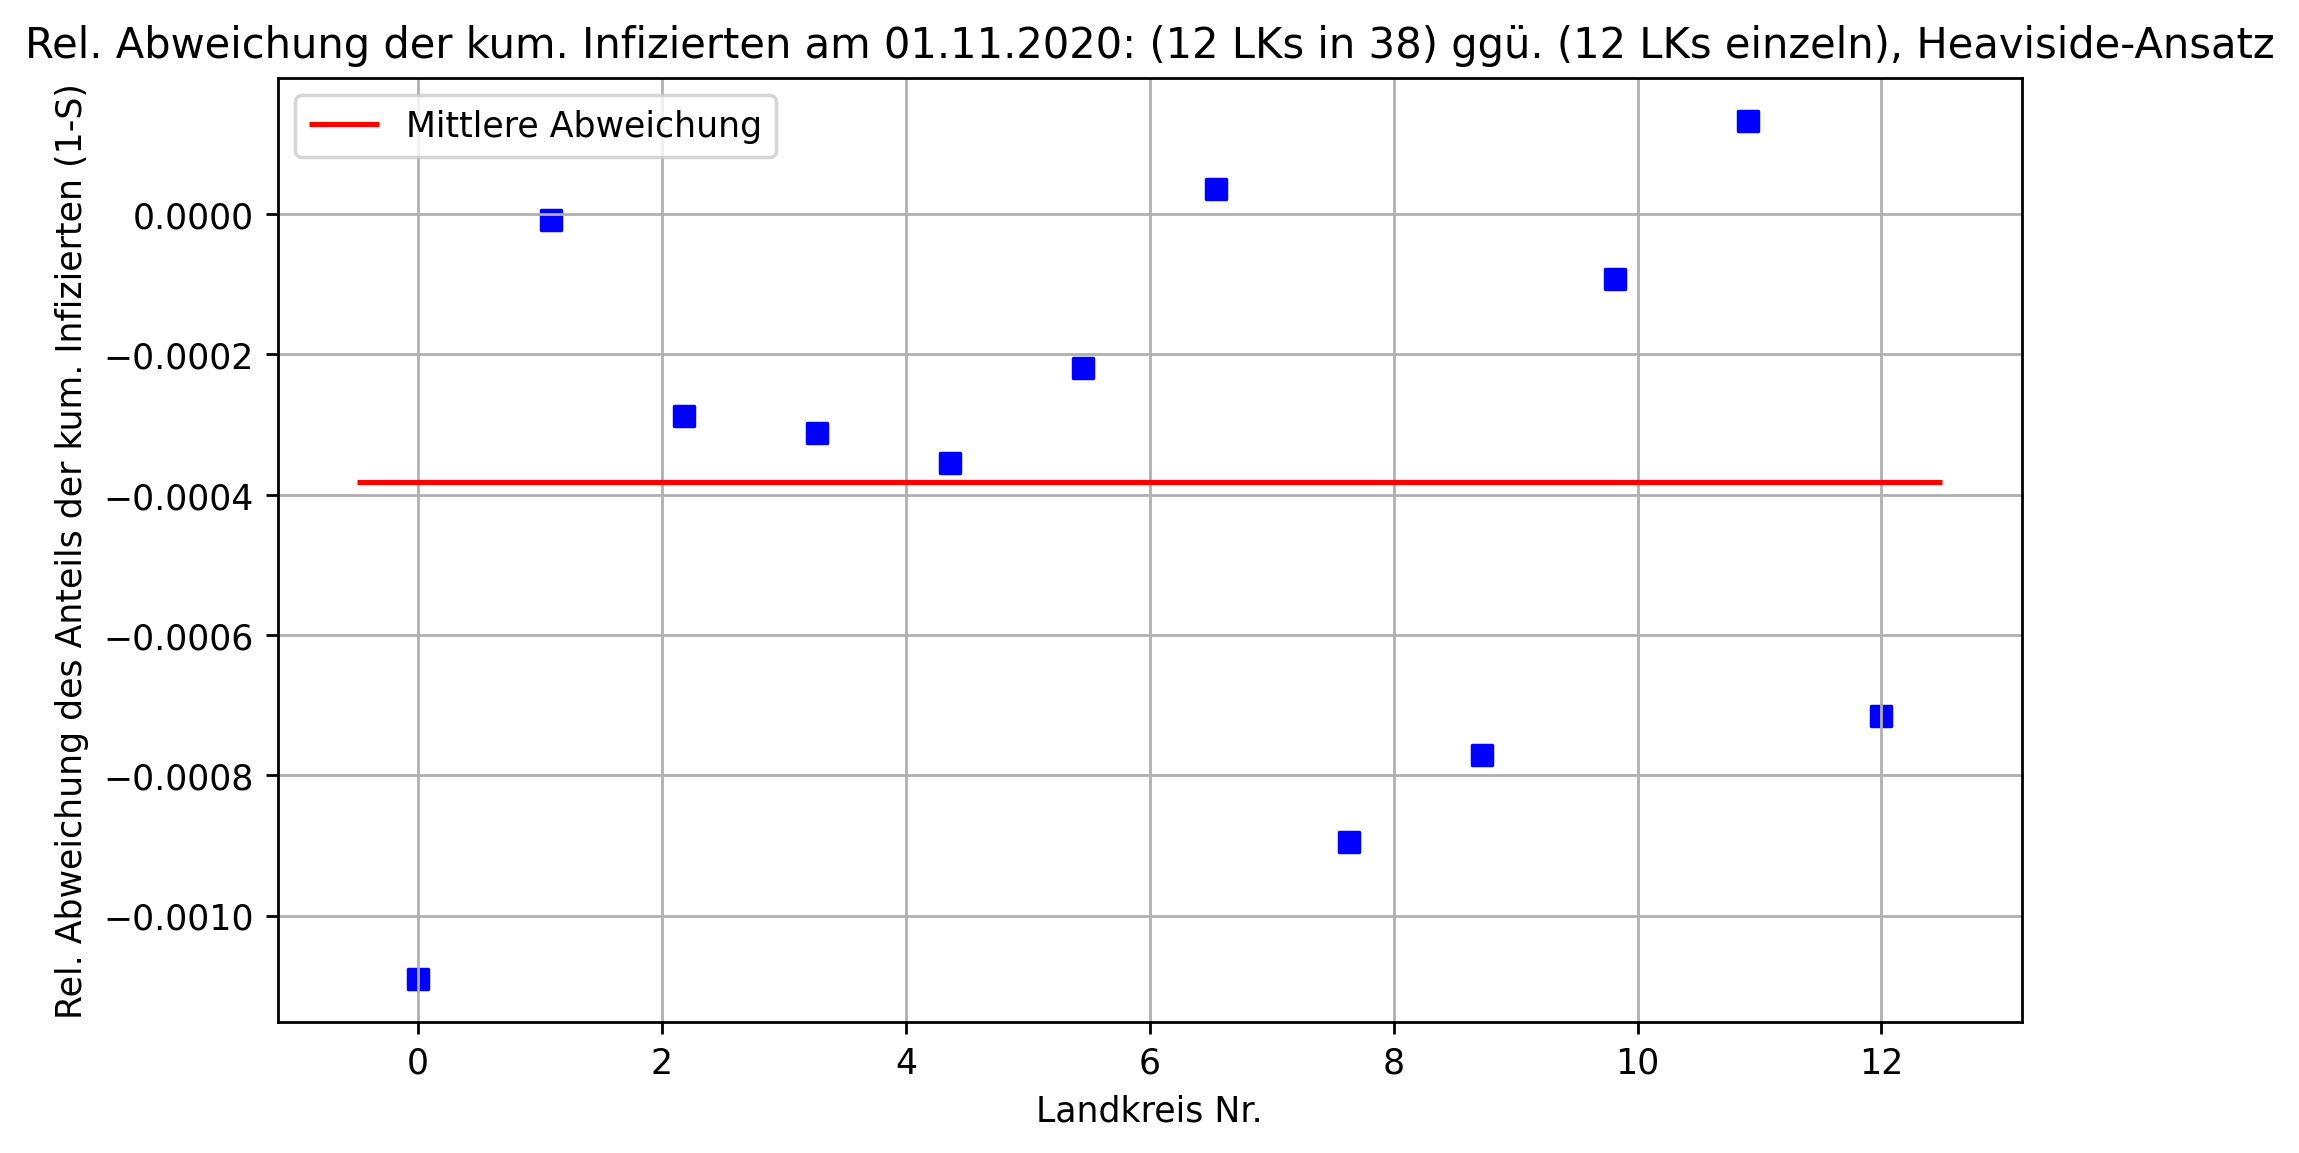

In [16]:
RKI_reference = np.zeros(12)
small_sim_h = np.zeros(12)
large_sim_h = np.zeros(12)

for i in range(12):
    RKI_reference[i] = (1-RKI_data[i][0][-1])
    small_sim_h[i] =  (1-sol1_12.y[i][-1])
    large_sim_h[i] = (1-sol1_38.y[i][-1])

avg_diff_large_small_h=np.mean((large_sim_h-small_sim_h)/small_sim_h)

plt.figure(figsize=(9,5),dpi=250)
plt.title("Rel. Abweichung der kum. Infizierten am 01.11.2020: (12 LKs in 38) ggü. (12 LKs einzeln), Heaviside-Ansatz")
plt.scatter(np.linspace(0,12,12),(large_sim_h-small_sim_h)/small_sim_h, marker='s',color='blue')
plt.xlabel('Landkreis Nr.')
plt.ylabel('Rel. Abweichung des Anteils der kum. Infizierten (1-S)')
plt.hlines(avg_diff_large_small_h,-0.5,12.5,color='red',label='Mittlere Abweichung')
plt.grid()
plt.legend()
plt.savefig("Media/Boundaries/network_size_h.pdf")